In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load the dataset
df = pd.read_csv("heart1.csv")

# Step 2: Handle missing values (if any)
df.dropna(inplace=True)

# Step 3: Separate features and target
X = df.drop(columns=['sex'])  # Replace 'target' with actual target column name if different
y = df['sex']

# Step 4: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6a: Train AdaBoost Classifier
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Step 6b: Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Step 7: Evaluate both models
print("=== AdaBoost Classification Report ===")
y_pred_ada = ada_model.predict(X_test)
print(classification_report(y_test, y_pred_ada))
print("Accuracy:", accuracy_score(y_test, y_pred_ada))

=== AdaBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.45      0.38      0.42        13
           1       0.84      0.88      0.86        48

    accuracy                           0.77        61
   macro avg       0.65      0.63      0.64        61
weighted avg       0.76      0.77      0.76        61

Accuracy: 0.7704918032786885


Round 1 | Feature: chol, Threshold: 335.0000, Polarity: -1, Error: 0.2871, Alpha: 0.4547
Round 2 | Feature: thal, Threshold: 3.0000, Polarity: 1, Error: 0.3155, Alpha: 0.3872
Round 3 | Feature: age, Threshold: 59.0000, Polarity: -1, Error: 0.3880, Alpha: 0.2280
Round 4 | Feature: target, Threshold: 0.0000, Polarity: -1, Error: 0.4062, Alpha: 0.1899
Round 5 | Feature: chol, Threshold: 262.0000, Polarity: -1, Error: 0.3928, Alpha: 0.2179

Accuracy: 76.24%
Precision: 0.7897
Recall: 0.8889
F1 Score: 0.8364
ROC-AUC: 0.7816


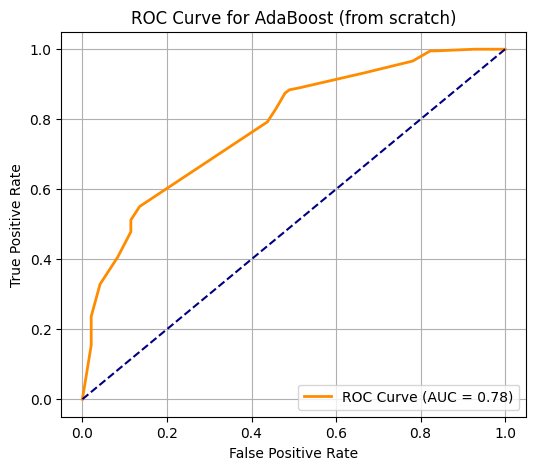

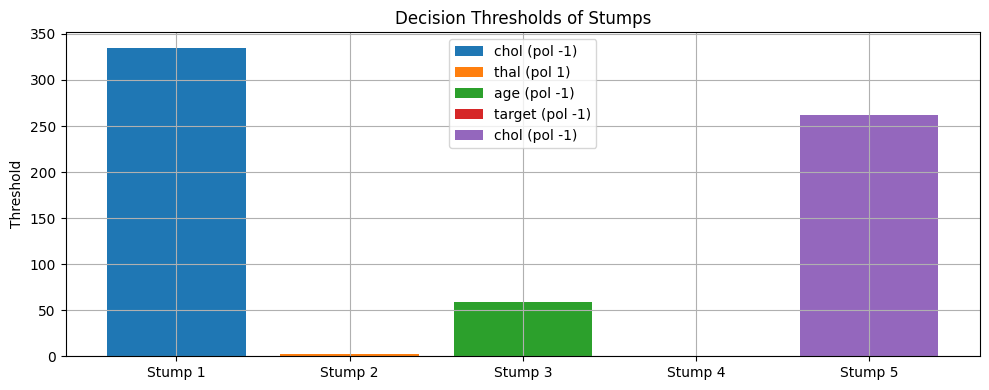

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# 1. Load the dataset
df = pd.read_csv("heart1.csv")  # Adjust path as needed

# 2. Preprocess: Map target (sex) to binary labels {-1, 1}
df['Label'] = df['sex'].map({0: -1, 1: 1})  # Convert 0 to -1

# 3. Select features (drop non-numeric and target)
feature_cols = df.drop(columns=['sex', 'Label']).select_dtypes(include=[np.number]).columns.tolist()
X = df[feature_cols].values
y = df['Label'].values
n_samples, n_features = X.shape

# 4. AdaBoost setup
T = 5
weights = np.ones(n_samples) / n_samples
alphas = []
stumps = []

def decision_stump(X, y, weights):
    n_samples, n_features = X.shape
    best_feature, best_threshold, best_polarity, min_error = None, None, None, float('inf')

    for feature_i in range(n_features):
        feature_values = X[:, feature_i]
        thresholds = np.unique(feature_values)

        for threshold in thresholds:
            for polarity in [1, -1]:
                predictions = np.ones(n_samples)
                predictions[polarity * feature_values < polarity * threshold] = -1
                misclassified = predictions != y
                error = np.sum(weights * misclassified)

                if error < min_error:
                    min_error = error
                    best_feature = feature_i
                    best_threshold = threshold
                    best_polarity = polarity

    return best_feature, best_threshold, best_polarity, min_error

# 5. Train AdaBoost
for t in range(T):
    feature, threshold, polarity, error = decision_stump(X, y, weights)
    alpha = 0.5 * np.log((1 - error + 1e-10) / (error + 1e-10))

    preds = np.ones(n_samples)
    preds[polarity * X[:, feature] < polarity * threshold] = -1

    weights *= np.exp(-alpha * y * preds)
    weights /= np.sum(weights)

    alphas.append(alpha)
    stumps.append((feature, threshold, polarity))

    print(f"Round {t+1} | Feature: {feature_cols[feature]}, Threshold: {threshold:.4f}, "
          f"Polarity: {polarity}, Error: {error:.4f}, Alpha: {alpha:.4f}")

# 6. Predict
def strong_classifier(X):
    final_pred = np.zeros(X.shape[0])
    for alpha, (feature, threshold, polarity) in zip(alphas, stumps):
        pred = np.ones(X.shape[0])
        pred[polarity * X[:, feature] < polarity * threshold] = -1
        final_pred += alpha * pred
    return np.sign(final_pred), final_pred  # Return raw scores too

y_pred, y_scores = strong_classifier(X)

# 7. Metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_scores)

print(f"\nAccuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# 8. ROC Curve
fpr, tpr, _ = roc_curve(y, y_scores)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for AdaBoost (from scratch)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 9. Stump thresholds
plt.figure(figsize=(10, 4))
for i, (feature, threshold, polarity) in enumerate(stumps):
    plt.bar(i, threshold, label=f"{feature_cols[feature]} (pol {polarity})")
plt.ylabel("Threshold")
plt.xticks(range(T), [f"Stump {i+1}" for i in range(T)])
plt.title("Decision Thresholds of Stumps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Initial Centroids:
[[150 112]
 [170 159]
 [150 173]]

Iteration 1 Centroids:
[[130.26041667 122.39583333]
 [167.47826087 151.34782609]
 [127.85326087 163.65217391]]

Iteration 2 Centroids:
[[128.96703297 122.17582418]
 [162.48648649 149.35135135]
 [126.48       163.99428571]]

Iteration 3 Centroids:
[[128.24444444 122.21111111]
 [160.06818182 149.11363636]
 [126.01775148 164.3964497 ]]

Iteration 4 Centroids:
[[127.86666667 122.21111111]
 [158.42857143 149.7755102 ]
 [125.67682927 164.66463415]]

Iteration 5 Centroids:
[[127.86666667 122.21111111]
 [157.64150943 151.22641509]
 [125.11875    164.55625   ]]

Iteration 6 Centroids:
[[127.86666667 122.21111111]
 [157.21818182 151.8       ]
 [124.85443038 164.52531646]]

Iteration 7 Centroids:
[[128.11235955 121.98876404]
 [156.36206897 152.05172414]
 [124.42948718 164.53205128]]

Iteration 8 Centroids:
[[128.6741573  121.74157303]
 [154.88709677 152.72580645]
 [123.86184211 164.73026316]]

Iteration 9 Centroids:
[[128.6741573  121.74157303

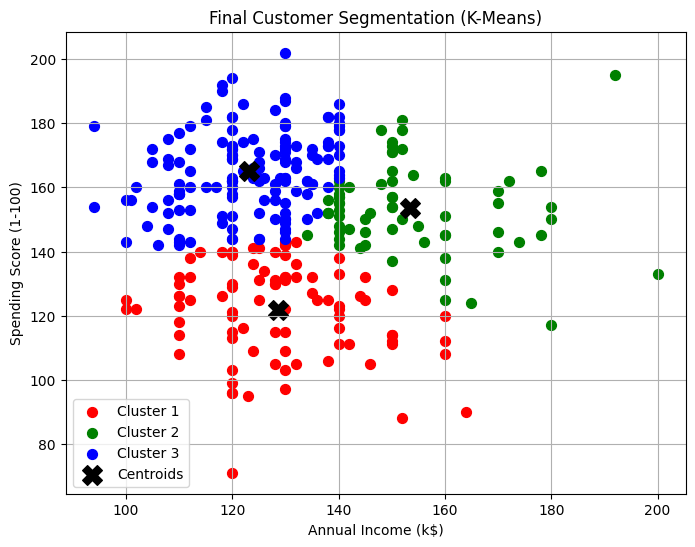

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('heart1.csv')
X = df[['trestbps', 'thalach']].values

# Parameters
K = 3
MAX_ITER = 10
np.random.seed(42)

# Initialize centroids randomly
centroids = X[np.random.choice(X.shape[0], K, replace=False)]

print("Initial Centroids:")
print(centroids)

for iteration in range(MAX_ITER):
    # Step 1: Assign points to nearest centroid
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    # Step 2: Calculate new centroids
    new_centroids = np.array([
        X[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k]
        for k in range(K)
    ])

    print(f"\nIteration {iteration + 1} Centroids:")
    print(new_centroids)

    # Stop if centroids have converged
    if np.allclose(centroids, new_centroids):
        print("\nConverged.")
        break

    centroids = new_centroids

# Plot final clusters
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.figure(figsize=(8, 6))

for k in range(K):
    cluster_points = X[labels == k]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, color=colors[k], label=f'Cluster {k+1}')

# Plot final centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='X', label='Centroids')

plt.title('Final Customer Segmentation (K-Means)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.show()